In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_09c import *

# Image transformation with PIL

In [3]:
idx=3

In [4]:
make_rgb._order=0 # set to high order

In [6]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [7]:
def get_il(tfms): return ImageList.from_files(path, tfms=tfms)

In [8]:
il = get_il(tfms)

In [9]:
il[idx]

tensor([[[0.6353, 0.7059, 0.6431,  ..., 0.5137, 0.4902, 0.4980],
         [0.7137, 0.6902, 0.5843,  ..., 0.5333, 0.5294, 0.5216],
         [0.5804, 0.5412, 0.4745,  ..., 0.5059, 0.4941, 0.5255],
         ...,
         [0.8039, 0.7686, 0.7451,  ..., 0.8314, 0.8471, 0.8863],
         [0.8000, 0.7843, 0.7608,  ..., 0.8980, 0.8863, 0.8745],
         [0.8157, 0.8235, 0.7725,  ..., 0.8039, 0.8510, 0.8627]],

        [[0.5725, 0.6706, 0.6314,  ..., 0.4667, 0.4431, 0.4510],
         [0.6784, 0.6706, 0.5725,  ..., 0.4863, 0.4824, 0.4745],
         [0.5725, 0.5176, 0.4549,  ..., 0.4588, 0.4471, 0.4784],
         ...,
         [0.7333, 0.6902, 0.6667,  ..., 0.7686, 0.7843, 0.8275],
         [0.7373, 0.7059, 0.6706,  ..., 0.8353, 0.8196, 0.8196],
         [0.7490, 0.7451, 0.6784,  ..., 0.6588, 0.6863, 0.6824]],

        [[0.3686, 0.5490, 0.4706,  ..., 0.3725, 0.3490, 0.3569],
         [0.4196, 0.4235, 0.3765,  ..., 0.3922, 0.3882, 0.3804],
         [0.3373, 0.2784, 0.2706,  ..., 0.3647, 0.3529, 0.

In [10]:
il.items[idx]

PosixPath('/home/quantran/.fastai/data/imagenette/train/n03000684/n03000684_13440.JPEG')

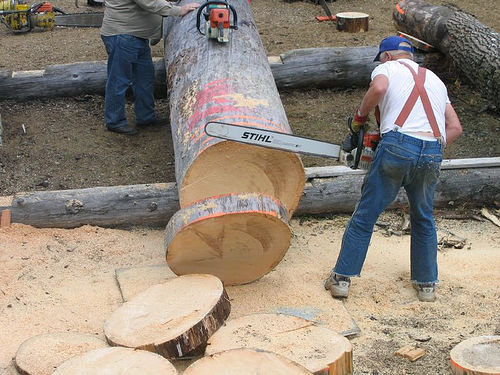

In [11]:
img = PIL.Image.open(il.items[idx])
img

In [12]:
img.size, type(img)

((500, 375), PIL.JpegImagePlugin.JpegImageFile)

In [17]:
img.getpixel((1,1))

(179, 158, 103)

In [18]:
import numpy as np

In [19]:
%timeit -n 10 a = np.array(PIL.Image.open(il.items[idx]))

1.65 ms ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## PIL Resize with different resampling method

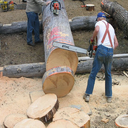

In [20]:
img.resize((128,128), resample=PIL.Image.ANTIALIAS)

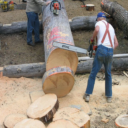

In [21]:
img.resize((128,128), resample=PIL.Image.BILINEAR)
# image is actually blurrer than the ANTIALIAS one

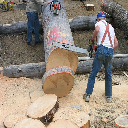

In [22]:
img.resize((128,128), resample=PIL.Image.NEAREST)
# distortion, but amplify small details

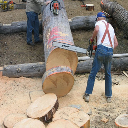

In [23]:
img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)
# 2 resamplings (bit better)

## Flip using PIL

In [24]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [25]:
import random

def pil_random_flip(x):
    # to be put in tfms
    # flip vertically 50% of the time
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<0.5 else x

In [26]:
# get a GPU-ready batch (bs=8) of imgs
il1 = get_il(tfms)
il1.items = [il1.items[idx]]*64
dl = DataLoader(il1, 8)
x = next(iter(dl))

In [27]:
x.shape,x.dtype

(torch.Size([8, 3, 128, 128]), torch.float32)

In [28]:
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)

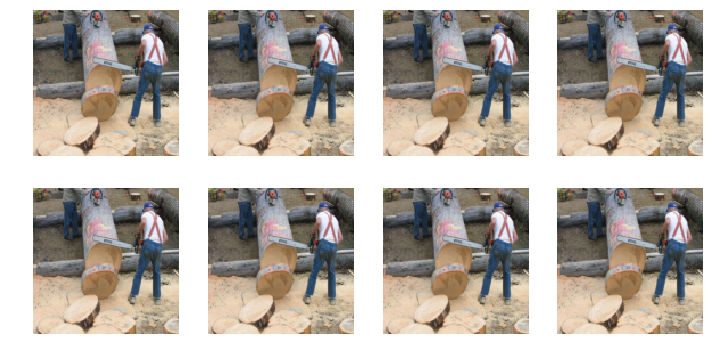

In [29]:
show_batch(x)

In [30]:
il1.tfms.append(pil_random_flip)

Reference on tfms and how it is used on image

```python
    def _get(self, i): 
        # use self.get(i) from children class of ItemList to get the item (see ImageList)
        # then apply tfms functions on it (with order)
        return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)
```

In [31]:
il1.tfms

[<function exp.nb_08.make_rgb(item)>,
 <function exp.nb_08.to_byte_tensor(item)>,
 <function exp.nb_08.to_float_tensor(item)>,
 <function __main__.pil_random_flip(x)>]

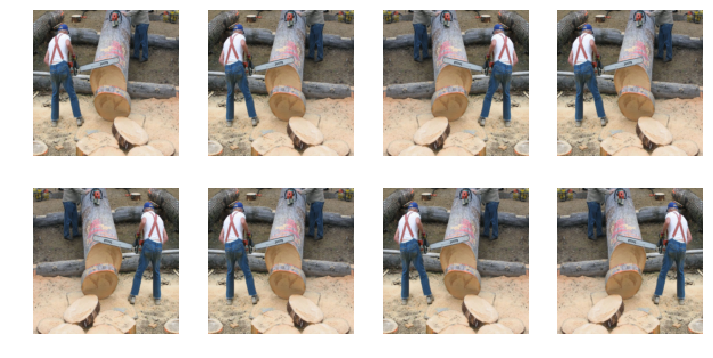

In [32]:
x = next(iter(dl))  # _getitem_ got called
show_batch(x)

#### Note: flip tfms should be done to the image while it is still a byte (uint8) stored in PIL img object. Doing flip tfms on tensor is slower!

In [33]:
make_rgb._order,ResizeFixed(128)._order,to_byte_tensor._order,to_float_tensor._order

(0, 10, 20, 30)

# PIL Transform class

In [34]:
class PilTransform(Transform): _order=11 # right after Resized (when it's still a PIL obj) and before Tensor conversion

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x


In [35]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

In [36]:
il1.tfms

[<function exp.nb_08.make_rgb(item)>,
 <function exp.nb_08.to_byte_tensor(item)>,
 <function exp.nb_08.to_float_tensor(item)>,

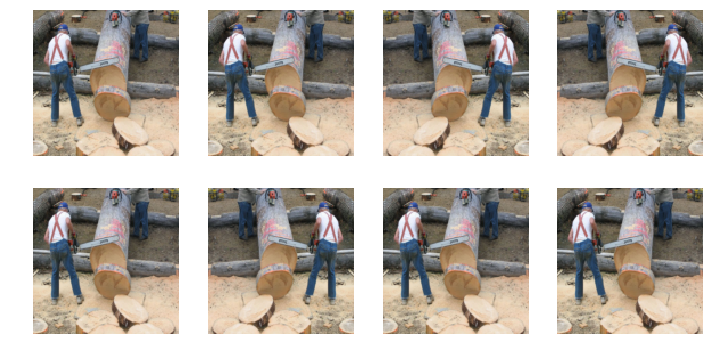

In [37]:
x = next(iter(dl))
show_batch(x)

## Dihedral group of PIL transform: horizontal + vertical flip and 4 90 degrees rotation

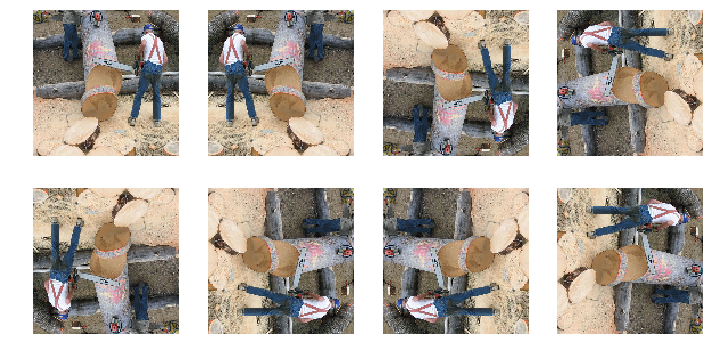

In [43]:
img = PIL.Image.open(il.items[idx])
img = img.resize((128,128), resample=PIL.Image.NEAREST)
_, axs = plt.subplots(2, 4, figsize=(12, 6))
for i,ax in enumerate(axs.flatten()):
    if i==0: ax.imshow(img) # img.transpose(0) is already one transform, so doing nothing requires a separate case, then we have 7 different transformations.
    else:    ax.imshow(img.transpose(i-1))
    ax.axis('off')

In [44]:
class PilRandomDihedral(PilTransform):
    def __init__(self, p=0.75): self.p=p*7/8 #Little hack to get the 1/8 identity dihedral transform taken into account.
    def __call__(self, x):
        if random.random()>self.p: return x
        return x.transpose(random.randint(0,6))

In [45]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomDihedral())

In [46]:
il1.tfms

[<function exp.nb_08.make_rgb(item)>,
 <function exp.nb_08.to_byte_tensor(item)>,
 <function exp.nb_08.to_float_tensor(item)>,

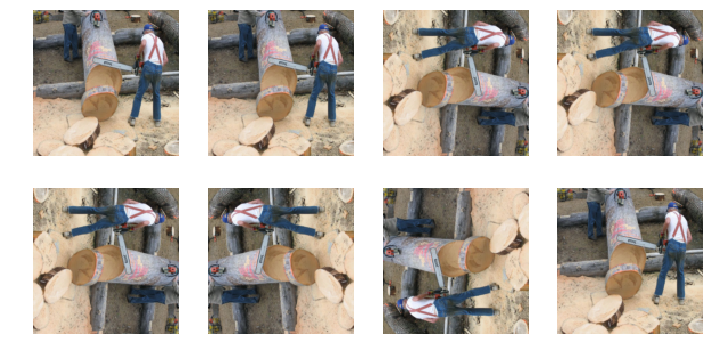

In [47]:
show_batch(next(iter(dl)))

## Random cropping

In [48]:
img = PIL.Image.open(il.items[idx])
img.size

(500, 375)

Note: we don't resize and crop, that does not make sense. We will crop first, then resize

#### NOte: if we decide to do transformation on byte (uint8), be extra careful when doing  'destructive' transformation (resize, crop, wasp ...). 

You don't want to do it in differente separate steps since they will round up each time -> you just add up the error.

-> Try to do them in 1 go (1 function if possible)

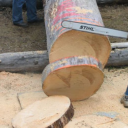

In [50]:
# provide top left + bottom right coords
img.crop((80,80,340,340)).resize((128,128), resample=PIL.Image.BILINEAR)

In [54]:
cnr2 = (80,80,340,340)
resample = PIL.Image.BILINEAR

In [59]:
%timeit -n 10 img.crop(cnr2).resize((128,128), resample=resample)

105 µs ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


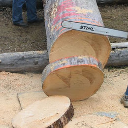

In [56]:
# we can do the crop and resize in the same call to transform, which will give a better result.
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [58]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

387 µs ± 3.31 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It's a little bit slower but still fast enough for our purpose, so we will use this

In [60]:
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

def default_crop_size(w,h): return [w,w] if w < h else [h,h] # square img with size min(w,h)

In [63]:
process_sz((128,128)),process_sz(128)

((128, 128), (128, 128))

# General Crop class

In [ ]:
class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w,h): return default_crop_size(w,h)

    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size

        # combine resize and crop into one call. self.get_corners will be overwritten
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(self, w, h): return (0,0,w,h) # placeholder?

# Validation set crop class (Center Crop)

In [84]:


# This is only for validation set as we don't do data aug on the validation set (ignore TTA for now)
# We only do a light tfm where we zoon a bit to the center
class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR): # zoom a bit to the center
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale] # calculate new crop size (does not have to be square)
    
    def get_corners(self, w, h, wc, hc): # calculate 2 corners (topleft bottomright) given crop size and center-crop requirement
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [86]:
# retired ResizeFixed
il1.tfms = [make_rgb, CenterCrop(128), to_byte_tensor, to_float_tensor]

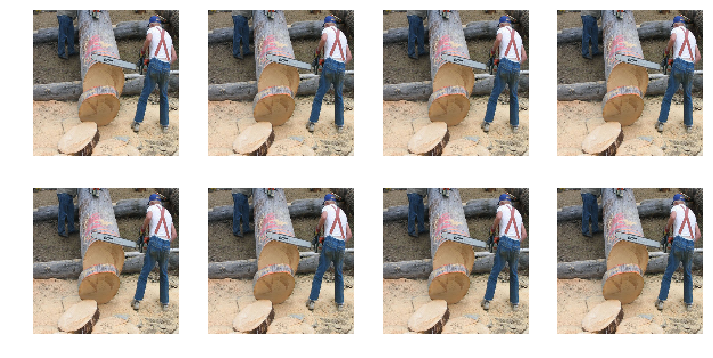

In [87]:
show_batch(next(iter(dl)))

# Train set crop class (Random resize crop)

#### Usual transformation for Imagenet 

consists of selecting 8 to 100% of the image area and a scale between 3/4 and 4/3 as a crop, then resizing it to the desired size. It combines some zoom and a bit of squishing at a very low computational cost.

In [89]:
# TODO: study later?
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio
    
    def get_corners(self, w, h, wc, hc):
        area = w*h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # Fallback to central crop
        left,top = randint(0,w-self.crop_size[0]),randint(0,h-self.crop_size[1])
        return (left, top, left+self.crop_size[0], top+self.crop_size[1])
        # Fallback to central crop

In [90]:
il1.tfms = [make_rgb, RandomResizedCrop(128), to_byte_tensor, to_float_tensor]

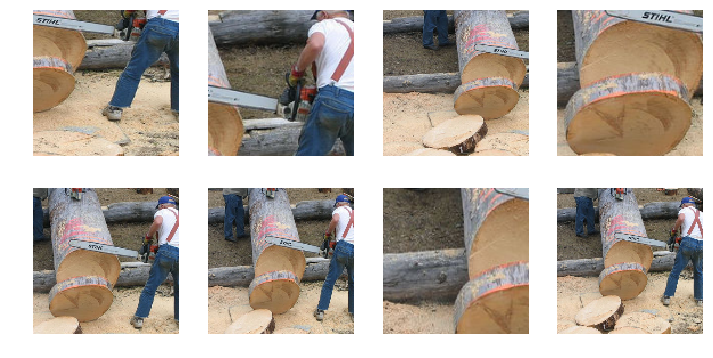

In [93]:
show_batch(next(iter(dl)))

Note that due to the [3/4 4/3] ratio crop, the obj in img may be squished or zoomed a bit. Jeremy argues that **this can contradict the domain knowledge, as the transformed img might not be reasonable within a certain knowledge anymore**

## Perspective warping (alternative to Random Resize Crop)